In [ ]:
## В этом ноутбуке эксперименты по чистке датасета, удалении из него нетиповых для Рф зданий, зароосших водоемов, затемненных дорог. 
## Дополнен качественными имиджами недостающих классов, однако из-за того, что это не 100% вертикальные сьемки, точность не повысилась, хотя на предикте
# сторонних фото она достаточно высокая. Исполнен на локальном ноутбуке юпитер, то есть, 
# исполняющим на колабе необходимо примонтировать гугл диск и произвести с контентом соответствующие операции.

In [72]:
# Импорт необходимых библиотек для работы с YOLO и обучения модели
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Импорт библиотек для работы с файловой системой и визуализации
import os
import matplotlib.pyplot as plt

print("Библиотеки успешно импортированы.")


Библиотеки успешно импортированы.


In [74]:
from ultralytics import YOLO


In [75]:
import os
import random
import cv2
from matplotlib import pyplot as plt
print("Библиотеки успешно импортированы.")

Библиотеки успешно импортированы.


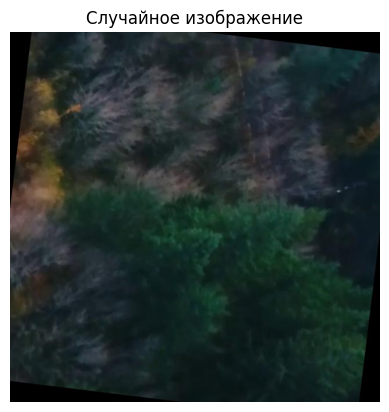

In [88]:
#  Проверяем путь к папке с изображениями, если надо посмотреть без меток
image_folder = r'C:\Users\Admin\Desktop\Land_use1\Evodrone2\train\images'

#  список всех файлов в папке
image_files = os.listdir(image_folder)

#  случайное изображение из списка
random_image = random.choice(image_files)

# полный путь к выбранному изображению
image_path = os.path.join(image_folder, random_image)

#  выбранное изображение
try:
    image = cv2.imread(image_path)

    # удалось ли загрузить изображение
    if image is not None:
        # Отобразите изображение с помощью matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Случайное изображение')
        plt.axis('off')
        plt.show()
    else:
        print(f'Не удалось загрузить изображение по пути: {image_path}')
except Exception as e:
    print(f'Произошла ошибка при загрузке изображения: {str(e)}')


In [89]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import cv2
import numpy as np
import os
import random


In [82]:
# Тренировка листания файлов в блокноте юпитер на 2 изображениях (метод иной, чем в пайчарм, через ipywidgets). Метод сработал, файлы листаются.
# We train to use anoither method to display changing images than we did in Pycharm. The method works correctly.
import ipywidgets as widgets
from IPython.display import display
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import io


# Пути к вашим изображениям

image_files = [
    r"C:\Users\Admin\Desktop\Land_use1\Evodrone2\train\images\hotel_jpg.rf.ca05f1b61bc9c5b4d80f1bde026b3715.jpg",  # Замените на путь к вашему первому изображению
    r"C:\Users\Admin\Desktop\Land_use1\Evodrone2\train\images\circus3_png.rf.199b971f51ec6da81dc427c2b1d26112.jpg"  # Замените на путь к вашему второму изображению
]

# Пустой список меток, так как мы пока не используем метки
label_files = [
    r"C:\Users\Admin\Desktop\Land_use1\Evodrone2\train\labels\hotel_jpg.rf.ca05f1b61bc9c5b4d80f1bde026b3715.txt",  # Пустой путь, так как у нас пока нет меток
    r"C:\Users\Admin\Desktop\Land_use1\Evodrone2\train\labels\circus3_png.rf.199b971f51ec6da81dc427c2b1d26112.txt"
]


# Пример списка названий классов 
class_names = ['Agricultural object', 'Fields', 'Forest', 'Grassland', 'Industrial facility', 'Power lines', 'Public facility', 'Residential facility', 'Road', 'Water']

current_image_index = 0

output = widgets.Output()

def show_image(index):
    with output:
        if 0 <= index < len(image_files):
            clear_output(wait=True)
            image_path = image_files[index]
            image = Image.open(image_path)
            plt.imshow(image)
            plt.axis('off')
            plt.show()

def on_next_clicked(b):
    global current_image_index
    current_image_index = (current_image_index + 1) % len(image_files)
    show_image(current_image_index)

def on_prev_clicked(b):
    global current_image_index
    current_image_index = (current_image_index - 1) % len(image_files)
    show_image(current_image_index)

prev_button = widgets.Button(description='Previous')
next_button = widgets.Button(description='Next')

prev_button.on_click(on_prev_clicked)
next_button.on_click(on_next_clicked)

display(widgets.HBox([prev_button, next_button]))
display(output)

show_image(current_image_index)

Output()

In [83]:
# Переименовываем файлы после робофлоу, чтобы сократить длину названий до допустмимой. 
import os
import shutil

def rename_and_move_files(src_images_dir, src_labels_dir, dst_images_dir, dst_labels_dir, dataset_type):
    if not os.path.exists(dst_images_dir):
        os.makedirs(dst_images_dir)
    if not os.path.exists(dst_labels_dir):
        os.makedirs(dst_labels_dir)

    image_files = [f for f in os.listdir(src_images_dir) if f.endswith('.jpg')]
    counter = 1

    if not image_files:
        print("Файлов нет, вывод невозможен.")
        return

    for image_file in image_files:
        # Составление новых имен файлов
        new_image_name = f"evodrone_{dataset_type}{counter}.jpg"
        new_label_name = f"evodrone_{dataset_type}{counter}.txt"

        # Пути к старым файлам
        old_image_path = os.path.join(src_images_dir, image_file)
        old_label_path = os.path.join(src_labels_dir, image_file.replace('.jpg', '.txt'))

        # Пути к новым файлам
        new_image_path = os.path.join(dst_images_dir, new_image_name)
        new_label_path = os.path.join(dst_labels_dir, new_label_name)

        # Перемещение и переименование файлов
        shutil.copy(old_image_path, new_image_path)
        shutil.copy(old_label_path, new_label_path)

        counter += 1

    # Выводим названия первых трех пар файлов (текст и jpg)
    print(f"Переименованные и перемещенные файлы:")
    for i in range(1, min(4, counter)):
        print(f"evodrone_{dataset_type}{i}.jpg, evodrone_{dataset_type}{i}.txt")

# Исходные и целевые директории
src_base_dir = r'C:\Users\Admin\Desktop\Land_use1\Evodrone2'
dst_base_dir = r'C:\Users\Admin\Desktop\Land_use1\Evodrone1'

# Переименование и перемещение файлов для тренировочного, валидационного и тестового наборов
for dataset_type in ['train', 'valid', 'test']:
    src_images_dir = os.path.join(src_base_dir, dataset_type, 'images')
    src_labels_dir = os.path.join(src_base_dir, dataset_type, 'labels')
    dst_images_dir = os.path.join(dst_base_dir, dataset_type, 'images')
    dst_labels_dir = os.path.join(dst_base_dir, dataset_type, 'labels')

    rename_and_move_files(src_images_dir, src_labels_dir, dst_images_dir, dst_labels_dir, dataset_type)



Переименованные и перемещенные файлы:
evodrone_train1.jpg, evodrone_train1.txt
evodrone_train2.jpg, evodrone_train2.txt
evodrone_train3.jpg, evodrone_train3.txt
Переименованные и перемещенные файлы:
evodrone_valid1.jpg, evodrone_valid1.txt
evodrone_valid2.jpg, evodrone_valid2.txt
evodrone_valid3.jpg, evodrone_valid3.txt
Переименованные и перемещенные файлы:
evodrone_test1.jpg, evodrone_test1.txt
evodrone_test2.jpg, evodrone_test2.txt
evodrone_test3.jpg, evodrone_test3.txt


In [91]:
import os

# Пути к папкам с метками для тренировочного, валидационного и тестового наборов данных нам надо поправить 3 класса, которыеи сместились
datasets_dirs = [
    r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\train\labels",
    r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\labels",
    r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\test\labels"
]

# Перебираем все три набора данных
for labels_dir in datasets_dirs:
    # Перебираем все файлы меток в каждом наборе
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(labels_dir, filename), 'r') as file:
                lines = file.readlines()
            
            fixed_lines = []
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                
                # Исправляем индексы классов
                if class_id == 8:
                    class_id = 7
                elif class_id == 9:
                    class_id = 8
                elif class_id == 10:
                    class_id = 9
                
                fixed_lines.append(f"{class_id} " + " ".join(parts[1:]) + "\n")
            
            # Перезаписываем исправленные строки в тот же файл
            with open(os.path.join(labels_dir, filename), 'w') as file:
                file.writelines(fixed_lines)

print("Исправление меток во всех наборах данных завершено.")


Исправление меток во всех наборах данных завершено.


In [95]:
# Листаем файлы во всем датасете, если необходимо проверить на соответствие меток весь датасет
import ipywidgets as widgets
from IPython.display import display
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np

# Пути к изображениям
image_dir = r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\train\images"
# Получаем список всех файлов jpg в директории
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

labels_dir = r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\train\labels"
# Получаем список всех файлов txt в директории
label_files = [os.path.join(labels_dir, f.replace('.jpg', '.txt')) for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Список названий классов 
class_names = ['0 Agricultural object', 
               '1 Fields',
               '2 Forest',
               '3 Grassland',
               '4 Industrial facility',
               '5 Power lines',
               '6 Public facility',
               '7 Residential facility',
               '8 Road',
               '9 Water']

current_image_index = 0

output = widgets.Output()

def display_image_with_labels(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        class_name = class_names[class_id]

        print(f"Class ID: {class_id}, Class Name: {class_name}")

        coords = np.array(parts[1:], dtype=np.float32)
        coords = coords.reshape(-1, 2) 

        h, w = image.shape[:2]
        coords[:, 0] *= w
        coords[:, 1] *= h
        coords = coords.astype(np.int32)

        cv2.polylines(image, [coords], isClosed=True, color=(0, 255, 0), thickness=2)

        # Вычисляем центроид полигона
        centroid = np.mean(coords, axis=0).astype(np.int32)

        # Добавляем название класса в центре полигона
        cv2.putText(image, class_name, tuple(centroid), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    return image

def show_image(index):
    with output:
        if 0 <= index < len(image_files):
            output.clear_output(wait=True)
            image_path = image_files[index]
            label_path = label_files[index]
            image = display_image_with_labels(image_path, label_path)
            plt.figure(figsize=(16, 12))
            plt.imshow(image)
            plt.axis('off')
            plt.show()

def on_next_clicked(b):
    global current_image_index
    current_image_index = (current_image_index + 1) % len(image_files)
    show_image(current_image_index)

def on_prev_clicked(b):
    global current_image_index
    current_image_index = (current_image_index - 1) % len(image_files)
    show_image(current_image_index)

prev_button = widgets.Button(description='Previous')
next_button = widgets.Button(description='Next')

prev_button.on_click(on_prev_clicked)
next_button.on_click(on_next_clicked)

display(widgets.HBox([prev_button, next_button]))
display(output)

show_image(current_image_index)


Output()

In [96]:
import os
import shutil
from PIL import Image

# Пути к папкам с изображениями и метками
image_dirs = [r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\train\images", 
              r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images", 
              r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\test\images"
             ]
label_dirs = [r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\train\labels",
              r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\labels", 
              r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\test\labels"
             ]

quarantine_dir = r"C:\Users\Admin\Desktop\Land_use1\Evodrone1\quarantine"

# Создаем папку карантин, если она еще не существует
if not os.path.exists(quarantine_dir):
    os.makedirs(quarantine_dir)

# Переменная для подсчета перемещенных файлов
moved_files_count = 0

# Проверяем каждую папку с метками
for i, label_dir in enumerate(label_dirs):
    for filename in os.listdir(label_dir):
        # Если было перемещено более 20 файлов, останавливаем процесс
        if moved_files_count > 20:
            print("Было перемещено более 20 файлов. Операция остановлена.")
            break

        label_path = os.path.join(label_dir, filename)
        
        # Если файл метки пуст, перемещаем соответствующий файл изображения в карантин
        if os.stat(label_path).st_size == 0:
            image_path = os.path.join(image_dirs[i], filename.replace('.txt', '.jpg'))
            if os.path.exists(image_path):
                shutil.move(image_path, quarantine_dir)
                moved_files_count += 1

        # Если нет соответствующего файла изображения, перемещаем файл метки в карантин
        image_path = os.path.join(image_dirs[i], filename.replace('.txt', '.jpg'))
        if not os.path.exists(image_path):
            shutil.move(label_path, quarantine_dir)
            moved_files_count += 1

# Проверяем каждую папку с изображениями
for i, image_dir in enumerate(image_dirs):
    for filename in os.listdir(image_dir):
        # Если было перемещено более 20 файлов, останавливаем процесс
        if moved_files_count > 20:
            print("Было перемещено более 20 файлов. Операция остановлена.")
            break

        image_path = os.path.join(image_dir, filename)
        
        # Если нет соответствующего файла метки, перемещаем файл изображения в карантин
        label_path = os.path.join(label_dirs[i], filename.replace('.jpg', '.txt'))
        if not os.path.exists(label_path):
            shutil.move(image_path, quarantine_dir)
            moved_files_count += 1



In [31]:
from PIL import Image
import os

# Пути к папкам с изображениями
image_dirs = [r"C:\Users\Admin\Desktop\Land_use1\Evodrone_NG1\train\images", 
              r"C:\Users\Admin\Desktop\Land_use1\Evodrone_NG1\valid\images", 
              r"C:\Users\Admin\Desktop\Land_use1\Evodrone_NG1\test\images"
             ]

# Словарь для подсчета изображений разных размеров
image_sizes = {}

# Проверяем каждую папку с изображениями
for image_dir in image_dirs:
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        with Image.open(image_path) as img:
            size = img.size
            if size in image_sizes:
                image_sizes[size] += 1
            else:
                image_sizes[size] = 1

# Выводим количество изображений каждого размера
for size, count in image_sizes.items():
    print(f"Количество изображений размером {size[0]}x{size[1]}: {count}")


Количество изображений размером 1463x820: 3
Количество изображений размером 1457x833: 9
Количество изображений размером 3840x2160: 357
Количество изображений размером 640x640: 902
Количество изображений размером 1920x701: 13
Количество изображений размером 2048x2048: 243
Количество изображений размером 2048x1152: 143
Количество изображений размером 5464x3640: 53
Количество изображений размером 1467x967: 4
Количество изображений размером 3992x2242: 15
Количество изображений размером 1461x815: 6
Количество изображений размером 5134x2888: 7
Количество изображений размером 1470x822: 2
Количество изображений размером 1483x936: 3
Количество изображений размером 1466x830: 3
Количество изображений размером 5472x3161: 1
Количество изображений размером 1429x804: 4
Количество изображений размером 5330x3551: 4
Количество изображений размером 4000x2250: 5
Количество изображений размером 4500x2998: 9
Количество изображений размером 1503x851: 6
Количество изображений размером 3982x2983: 4
Количество 

In [97]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Train the model with 2 GPUs
results = model.train(data='data.yaml', epochs=20, imgsz=640, device=[0, 1])

100%|█████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:05<00:00, 1.12MB/s]


New https://pypi.org/project/ultralytics/8.0.218 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.0 torch-2.1.1+cpu 


ValueError: Invalid CUDA 'device=0,1' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [100]:

prediction_results = model.predict(source=к"C:\Users\Admin\Desktop\Land_use1\berlin\berlin197_image.png")  # сохранить результат предсказания в переменной



image 1/1 C:\Users\Admin\Desktop\Land_use1\berlin\berlin197_image.png: 608x640 2 Forests, 1 Industrial facility, 3 Residential facilitys, 203.3ms
Speed: 4.0ms preprocess, 203.3ms inference, 6.7ms postprocess per image at shape (1, 3, 608, 640)


In [101]:
#Валидация
from ultralytics import YOLO


# Validate the model
model.val()  # оцените производительность модели на наборе проверки
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95(B)
metrics.box.map50  # map50(B)
metrics.box.map75  # map75(B)
metrics.box.maps   # a list contains map50-95(B) of each category
metrics.seg.map    # map50-95(M)
metrics.seg.map50  # map50(M)
metrics.seg.map75  # map75(M)
metrics.seg.maps   # a list contains map50-95(M) of each category

Ultralytics YOLOv8.0.216 🚀 Python-3.10.0 torch-2.1.1+cpu CPU (12th Gen Intel Core(TM) i5-12400F)


val: Scanning C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\labels.cache... 244 images, 0 backgrounds, 0 corrupt: 10

val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid118.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid136.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid152.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid153.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid206.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid227.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid228.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid229.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        244       1237      0.588      0.475      0.493      0.386      0.587      0.487      0.481       0.37
 Agricultural facility        244         77       0.85      0.857      0.874      0.742      0.851      0.893      0.876      0.742
                Fields        244         18      0.729          1      0.995      0.995      0.725          1      0.995      0.995
                Forest        244        204      0.497      0.559      0.416      0.293      0.487      0.572      0.398       0.25
             Grassland        244        343      0.857      0.489      0.632      0.467      0.851      0.493      0.596      0.387
   Industrial facility        244         21      0.904      0.714      0.742      0.579      0.896      0.714      0.705      0.593
           Power lines        244         75      0.641      0.253      0.292      0.194       0.64      0.284      0.303      0.163
       Public Facility        244          9      0.296      0.333   

val: Scanning C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\labels.cache... 244 images, 0 backgrounds, 0 corrupt: 10

val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid118.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid136.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid152.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid153.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid206.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid227.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid228.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\Admin\Desktop\Land_use1\Evodrone1\valid\images\evodrone_valid229.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        244       1237      0.588      0.475      0.493      0.386      0.587      0.487      0.481       0.37
 Agricultural facility        244         77       0.85      0.857      0.874      0.742      0.851      0.893      0.876      0.742
                Fields        244         18      0.729          1      0.995      0.995      0.725          1      0.995      0.995
                Forest        244        204      0.497      0.559      0.416      0.293      0.487      0.572      0.398       0.25
             Grassland        244        343      0.857      0.489      0.632      0.467      0.851      0.493      0.596      0.387
   Industrial facility        244         21      0.904      0.714      0.742      0.579      0.896      0.714      0.705      0.593
           Power lines        244         75      0.641      0.253      0.292      0.194       0.64      0.284      0.303      0.163
       Public Facility        244          9      0.296      0.333   

array([    0.74238,       0.995,     0.24973,     0.38678,     0.59324,     0.16323,     0.14689,     0.16483,     0.26285,           0])